# Notebook 3

## Supervised Learning Using simple features

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random

import pickle
import warnings
warnings.filterwarnings('ignore')
import re
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import nltk

In [2]:
df= pd.read_pickle("data/simple_features.pkl")

In [3]:
df.columns

Index(['original_text', 'label', 'preprocessed', 'word_count',
       'avg_word_count', 'syllable_count', 'uncommon', 'difficult_words',
       'stem', 'discourse', 'cohesive_features', 'flesch', 'dale', 'mcalpine',
       'nouns_adjs', 'normalized', 'aoa'],
      dtype='object')

In [4]:
df.shape

(403608, 17)

In [5]:
# noticed that I named a column wrong. It's supposed to be average word length not count
df.rename({'avg_word_count': 'avg_word_length'}, axis=1, inplace=True)

In [6]:
#let's scale the numerical values
cols = ['word_count','avg_word_length', 'syllable_count', 'uncommon', 'difficult_words',\
                  'discourse', 'cohesive_features', 'flesch', 'dale', 'mcalpine','nouns_adjs','label']

In [7]:
df=df[cols]

In [8]:
df.head()

,word_count,avg_word_length,syllable_count,uncommon,difficult_words,discourse,cohesive_features,flesch,dale,mcalpine,nouns_adjs,label
0,35,4.485714,1.371429,14,7,4,2,52.87,11.24,48.0,0.228571,1
1,19,6.000000,1.789474,14,8,2,1,35.27,14.55,23.0,0.315789,1
2,40,4.725000,1.400000,15,9,7,3,47.80,11.15,57.0,0.175000,1
3,32,6.281250,1.781250,22,14,0,1,22.08,14.60,38.0,0.593750,1
4,20,4.650000,1.350000,7,4,0,2,68.10,8.58,29.0,0.400000,1


We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively. We'll use `split` from `numpy` to split the data into train, dev, and test separately. We'll call these `train_df`, `dev_df`, and `test_df`.  Note that `split` does not shuffle, so we'll use `DataFrame.sample()` and randomly resample our entire dataset to get a random shuffle before the split.

In [9]:
#split the data into training,dev and testing
train_df,dev_df,test_df=np.split(df.sample(frac=1,random_state=42), 
                                 [int(.8*len(df)), 
                                  int(.9*len(df))])

In [10]:
print("There are {} instances in the train dataset".format(train_df.shape[0]))
print("There are {} instances in the dev dataset".format(dev_df.shape[0]))
print("There are {} instances in the test dataset".format(test_df.shape[0]))

There are 322886 instances in the train dataset
There are 40361 instances in the dev dataset
There are 40361 instances in the test dataset


## Scaling the features

In [14]:
# training data
X_train = train_df.loc[:, train_df.columns != 'label'].to_numpy()
y_train = train_df['label']

#dev data
X_dev= dev_df.loc[:, dev_df.columns != 'label'].to_numpy()
y_dev = dev_df['label']

# test data
X_test=test_df.loc[:, test_df.columns != 'label'].to_numpy()
y_test = test_df['label']

 `MinMaxScaler(feature_range = (0, 1))` will transform each value in the column proportionally within the range [0,1]. Use this as the first scaler choice to transform a feature, as it will preserve the shape of the dataset (no distortion).

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

In [34]:
X_train_scaled

array([[0.24657534, 0.22307692, 0.0625    , ..., 0.37567171, 0.23853211,
        0.2       ],
       [0.16438356, 0.3021978 , 0.16071429, ..., 0.48216903, 0.13761468,
        0.35714286],
       [0.53424658, 0.32082552, 0.13414634, ..., 0.57303371, 0.48623853,
        0.29268293],
       ...,
       [0.12328767, 0.26573427, 0.04545455, ..., 0.47972643, 0.11009174,
        0.27272727],
       [0.16438356, 0.34615385, 0.16071429, ..., 0.5925745 , 0.1559633 ,
        0.35714286],
       [0.20547945, 0.31221719, 0.05882353, ..., 0.57694187, 0.17431193,
        0.29411765]])

## Logistic Regression

In [15]:
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
clf= LogisticRegression(solver="sag",random_state=42)
clf.fit(X_train_scaled,np.array(y_train))

LogisticRegression(random_state=42, solver='sag')

In [16]:
preds=clf.predict(X_test_scaled)

In [17]:
f1 = f1_score(y_test,preds)

In [18]:
print(f1)

0.6215153412648716


### Cross Validation

In [19]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X_train_scaled, y_train)

print('Cross-validation scores (3-fold):', cv_scores)
print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation scores (3-fold): [0.62691629 0.62263654 0.62234232 0.62578008 0.62545488]
Mean cross-validation score (3-fold): 0.625


# Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap= True,
 max_depth=70,
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=800)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [23]:
from sklearn.metrics import f1_score, accuracy_score

rf_acc = accuracy_score(y_test, rf_preds)*100
rf_f1 = f1_score(y_test, rf_preds)*100
rf_training_score = rf.score(X_train, y_train)

(68.72723668888283, 70.34443870118886)

In [24]:
rf_acc, rf_f1, rf_training_score

(68.72723668888283, 70.34443870118886, 0.8799297584906128)

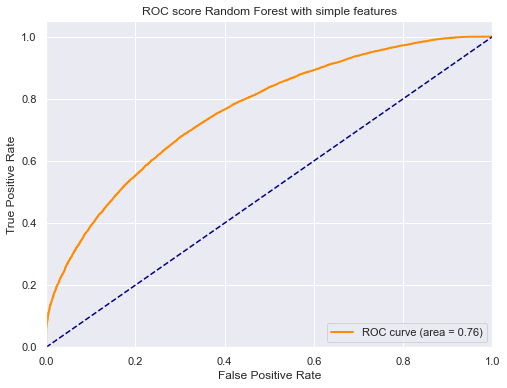

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

y_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=1)
area = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(8,6))
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score Random Forest with simple features')
plt.legend(loc="lower right")
plt.savefig('figures/ROC_RF_simplefeatures.jpg')

In [25]:
pickle.dump(rf, open('models/random_forest.pkl', 'wb'))

# Gradient Boosted Decision Tree

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

glf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 42)
glf.fit(X_train, y_train)

print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.51
Accuracy of GBDT classifier on test set: 0.51


# XGBoost

In [56]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [57]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc= sc.transform(X_test)

In [58]:
xgb_cl = xgb.XGBClassifier()

In [59]:
xgb_cl.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

0.6532791556205247

### Hyperparameter Tuning of XGBoost with GridSearchCV

In [45]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In the grid, I fixed subsample and colsample_bytree to recommended values to speed things up and prevent overfitting.
We will import GridSearchCV from sklearn.model_selection, instantiate and fit it to our preprocessed data:

In [54]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_train_sc, y_train)

In [47]:
grid_cv.best_score_

0.7055421581807623

In [61]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic"
)

In [62]:
from sklearn.metrics import roc_auc_score

_ = final_cl.fit(X_train_sc, y_train)

preds = final_cl.predict(X_test_sc)

accuracy_score(y_test, preds)

0.493198880107034

## SVM

A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.
A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. In other words, you can say a low value of gamma considers only nearby points in calculating the separation line, while a high value of gamma considers all the data points in the calculation of the separation line.

In [ ]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import validation_curve

param_range = np.logspace(-7,-2,6)
clf = SVC(kernel = 'rbf', C = 1, random_state=42)
    
train_scores, test_scores = validation_curve(clf, X_train_scaled, y_train, 
                                                 param_name='gamma', 
                                                 param_range=param_range, cv=3, scoring="accuracy")

training_scores = np.mean(train_scores, axis=1)
testing_scores = np.mean(test_scores, axis=1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
a=training_scores
b =testing_scores

# Remember to comment it out before submitting the notebook
# uncomment to plot

x = np.arange(-7, -1, 1)
plt.figure()
plt.plot(x, a, label="Avg Train Acc")
plt.plot(x, b, label="Avg Test Acc")
plt.xticks(x)
plt.xlabel('log scale: gamma parameter')
plt.ylabel("Accuracy")
plt.legend()
plt.show()